<center><h1> TensorFlow 基础：线性回归</h1></center>

# 读入MasterFile

In [1]:
import pandas as pd
MasterFile=pd.read_csv('/mnt/zhoujing/data/faces/FaceScore.csv') 
print(MasterFile.shape)
MasterFile[0:5]

(5500, 2)


,Filename,Rating
0,ftw1.jpg,4.083333
1,ftw10.jpg,3.666667
2,ftw100.jpg,1.916667
3,ftw101.jpg,2.416667
4,ftw102.jpg,3.166667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f692aefc210>]],
      dtype=object)

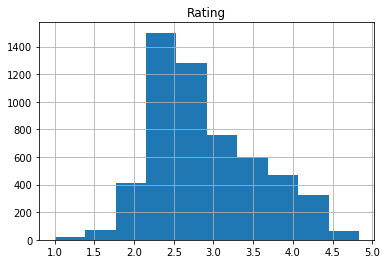

In [2]:
MasterFile.hist()     

# 准备X+Y数据

In [3]:
import numpy as np
from PIL import Image

FileNames=MasterFile['Filename']
N=len(FileNames)
IMSIZE=128
X=np.zeros([N,IMSIZE,IMSIZE,3])
for i in range(N):
    MyFile=FileNames[i]
    Im=Image.open('/mnt/zhoujing/data/faces/images/'+MyFile)
    Im=Im.resize([IMSIZE,IMSIZE])
    Im=np.array(Im)/255
    X[i,]=Im
Y=np.array(MasterFile['Rating']).reshape([N,1])
Y=(Y-np.mean(Y))/np.std(Y)

# 切分：Training+Validation

In [4]:
from sklearn.model_selection import train_test_split
X0,X1,Y0,Y1=train_test_split(X,Y,test_size=0.5,random_state=0)

# 颜值数据展示

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<Figure size 432x288 with 0 Axes>

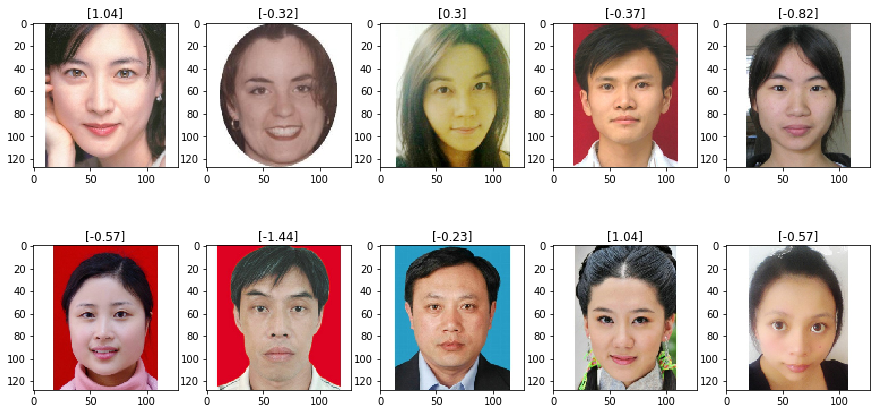

In [5]:
from matplotlib import pyplot as plt
plt.figure()
fig,ax=plt.subplots(2,5)
fig.set_figheight(7.5)
fig.set_figwidth(15)
ax=ax.flatten()
for i in range(10):
    ax[i].imshow(X0[i,:,:,:])
    ax[i].set_title(np.round(Y0[i],2))

# TensorFlow 实现：模型设计

In [18]:
from keras.layers import Dense, Flatten, Input
from keras import Model

input_layer=Input([IMSIZE,IMSIZE,3])
x=input_layer
x=Flatten()(x)
x=Dense(1)(x)
output_layer=x
model=Model(input_layer,output_layer)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49153     
Total params: 49,153
Trainable params: 49,153
Non-trainable params: 0
_________________________________________________________________


# TensorFlow 实现：施工方案


$$\mbox{MSE}=\sum_{i=1}^n \Big (Y_i-\beta_0-\sum_{i=1}^p\sum_{j=1}^q \sum_{k=1}^3 X_{ijk}\beta_{ijk} \Big)^2.$$


In [19]:
from keras.optimizers import Adam
model.compile(loss='mse',optimizer=Adam(lr=0.001),metrics=['mse'])

# TensorFlow中回调函数的使用：

### 回调函数是一类函数的集合，在使用fit函数进行训练的时候，会出现无法确定训练次数、是否过拟合，同时无法人为的干扰实现控制优化的过程，因此回调函数的目的就是通过设置一定的条件从而使模型在训练过程中达到最佳状态。

### 其中较为重要的三个部分如下
### Tensorboard、Earlystopping、ModelCheckpoint

In [11]:
import os
from keras.callbacks import EarlyStopping,TensorBoard,ModelCheckpoint
logdir = os.path.join('save_h5file')
#判断文件夹是否创建成功
if not os.path.exists(logdir):
    os.mkdir(logdir)#不存在就创建新的文件夹
output_model_file = os.path.join(logdir,"facescore.h5")

tfcallbacks = [
    TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None),
    ModelCheckpoint(output_model_file,monitor='val_loss',verbose=2,save_best_only=True,mode = 'min'),
    EarlyStopping(patience = 5,min_delta=0)
]


In [21]:
model.fit(X0,Y0,validation_data=[X1,Y1],batch_size=100,epochs=100,callbacks = tfcallbacks)

Train on 2750 samples, validate on 2750 samples
Epoch 1/100
2750/2750 [==============================] - 1s 478us/step - loss: 1.5216 - mse: 1.5216 - val_loss: 0.9866 - val_mse: 0.9866

Epoch 00001: val_loss improved from inf to 0.98662, saving model to save_h5file/facescore.h5
Epoch 2/100
2750/2750 [==============================] - 2s 557us/step - loss: 0.9094 - mse: 0.9094 - val_loss: 0.8877 - val_mse: 0.8877

Epoch 00002: val_loss improved from 0.98662 to 0.88767, saving model to save_h5file/facescore.h5
Epoch 3/100
2750/2750 [==============================] - 1s 515us/step - loss: 0.8260 - mse: 0.8260 - val_loss: 0.8380 - val_mse: 0.8380

Epoch 00003: val_loss improved from 0.88767 to 0.83805, saving model to save_h5file/facescore.h5
Epoch 4/100
2750/2750 [==============================] - 2s 660us/step - loss: 0.8265 - mse: 0.8265 - val_loss: 0.7920 - val_mse: 0.7920

Epoch 00004: val_loss improved from 0.83805 to 0.79198, saving model to save_h5file/facescore.h5
Epoch 5/100
2750

# Keras 学习率设置

#### keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

当学习停滞时，减少2倍或10倍的学习率常常能获得较好的效果。

    monitor：被监测的量
    factor：每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
    patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
    mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
    epsilon：阈值，用来确定是否进入检测值的“平原区”
    cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
    min_lr：学习率的下限

In [20]:
from keras.callbacks import EarlyStopping,TensorBoard,ModelCheckpoint,ReduceLROnPlateau
logdir = os.path.join('save_h5file')
#判断文件夹是否创建成功
if not os.path.exists(logdir):
    os.mkdir(logdir)#不存在就创建新的文件夹
output_model_file = os.path.join(logdir,"facescore.h5")

tfcallbacks = [
    TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None),
    ModelCheckpoint(output_model_file,monitor='val_loss',verbose=2,save_best_only=True,mode = 'min'),
    EarlyStopping(patience = 6,min_delta=0),
    ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')
]
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')
model.fit(X0,Y0,validation_data=[X1,Y1],batch_size=100,epochs=100,callbacks = tfcallbacks)

Train on 2750 samples, validate on 2750 samples
Epoch 1/100
2750/2750 [==============================] - 1s 534us/step - loss: 1.5799 - mse: 1.5799 - val_loss: 1.1415 - val_mse: 1.1415

Epoch 00001: val_loss improved from inf to 1.14155, saving model to save_h5file/facescore.h5
Epoch 2/100
2750/2750 [==============================] - 1s 487us/step - loss: 0.9437 - mse: 0.9437 - val_loss: 0.8858 - val_mse: 0.8858

Epoch 00002: val_loss improved from 1.14155 to 0.88585, saving model to save_h5file/facescore.h5
Epoch 3/100
2750/2750 [==============================] - 1s 467us/step - loss: 0.8599 - mse: 0.8599 - val_loss: 0.9033 - val_mse: 0.9033

Epoch 00003: val_loss did not improve from 0.88585
Epoch 4/100
2750/2750 [==============================] - 1s 452us/step - loss: 0.8772 - mse: 0.8772 - val_loss: 0.8626 - val_mse: 0.8626

Epoch 00004: val_loss improved from 0.88585 to 0.86257, saving model to save_h5file/facescore.h5
Epoch 5/100
2750/2750 [==============================] - 1s 50

2750/2750 [==============================] - 1s 422us/step - loss: 0.5563 - mse: 0.5563 - val_loss: 0.6651 - val_mse: 0.6651

Epoch 00040: val_loss did not improve from 0.66422
Epoch 41/100
2750/2750 [==============================] - 1s 430us/step - loss: 0.5564 - mse: 0.5564 - val_loss: 0.6654 - val_mse: 0.6654

Epoch 00041: val_loss did not improve from 0.66422
Epoch 42/100
2750/2750 [==============================] - 1s 431us/step - loss: 0.5561 - mse: 0.5561 - val_loss: 0.6648 - val_mse: 0.6648

Epoch 00042: val_loss did not improve from 0.66422


# 模型预测：给照片打分

array([[-0.74447113]], dtype=float32)

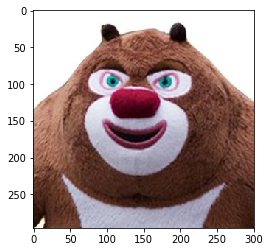

In [21]:
MyPic=Image.open('xiongda.jpg')
plt.imshow(MyPic)
MyPic=MyPic.resize((IMSIZE,IMSIZE))        
MyPic=np.array(MyPic)/255                  
MyPic=MyPic.reshape((1,IMSIZE,IMSIZE,3))                       
model.predict(MyPic)

In [27]:
from keras.models import load_model
renew_model = load_model('./save_h5file/facescore.h5')
renew_model.layers